# Department Store Sales Forecasting

## Time Series Analysis (3/3)

## Contents
- [Data Import](#Data-Import)
- [Data Modeling](#Data-Modeling)
    - Linear model
    - ARIMA model
    - SARIMAX model
- [Evaluation](#Evaluation)

## Data Import 

### Libraries

In [43]:
# Import libraries
import warnings

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [44]:
# Change the option to display with no max
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

### Data Import

In [45]:
# Read in the data
df = pd.read_csv(
    "../data/4521_department_stores_v2_clean.csv", index_col="date", parse_dates=True
)

# Review
df.head()

,sales
date,
1992-01-01,14134
1992-02-01,14472
1992-03-01,14543
1992-04-01,14529
1992-05-01,14634


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 374 entries, 1992-01-01 to 2023-02-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   sales   374 non-null    int64
dtypes: int64(1)
memory usage: 5.8 KB


In [47]:
df.isnull().sum()

sales    0
dtype: int64

### Autocorrelation

In [48]:
# Create values for serial correlation (lagged version)
df["sales_lag_1"] = df["sales"].shift(1)
df["sales_lag_2"] = df["sales"].shift(2)
df["sales_lag_3"] = df["sales"].shift(3)
df["sales_lag_4"] = df["sales"].shift(4)

# Create a variable called `time` that represents `t` variable
df["time"] = range(0, df.shape[0])

# Calculate the correlations among these columns.
df.corr()

,sales,sales_lag_1,sales_lag_2,sales_lag_3,sales_lag_4,time
sales,1.000000,0.993423,0.988596,0.986508,0.984482,-0.791388
sales_lag_1,0.993423,1.000000,0.993395,0.988571,0.986521,-0.790178
sales_lag_2,0.988596,0.993395,1.000000,0.993428,0.988642,-0.789053
sales_lag_3,0.986508,0.988571,0.993428,1.000000,0.993394,-0.787549
sales_lag_4,0.984482,0.986521,0.988642,0.993394,1.000000,-0.785912
time,-0.791388,-0.790178,-0.789053,-0.787549,-0.785912,1.000000


In [49]:
### Save clean dataframe as csv file

In [50]:
# Save dataset in csv file
df.to_csv("../data/4521_department_stores_v3_after_eda.csv")

## Data Modeling

#### Define a function that plots time series data and time series prediction for various models. 

In [51]:
def plot_preds(train, test, train_preds, test_preds, suptitle=None, truncate=False):
    """
    Reference: GA's 1002 lab time series modeling

    Plot time series data and time series predictions.
    The variables train, test, train preds, and test preds should have time series
    indices.

    suptitle -- an optional argument that adds a super-title to the plot;
        you can use it to specify what model you're plotting predictions
        off of

    truncate -- an optional integer argument that truncates how much of the
        training predictions are plotted; specify an integer to not plot
        that many of the first training predictions. (this will most often
        be the integer d, the differencing order.)
    """
    plt.figure(figsize=(12, 6))

    plt.plot(train, label="training data")
    plt.plot(test, label="testing data")

    if truncate:
        plt.plot(train_preds.iloc[truncate:], linestyle="--", label="training preds")
    else:
        plt.plot(train_preds, linestyle="--", label="training preds")
    plt.plot(test_preds, linestyle="--", label="testing preds")

    plt.title("Department Stores Monthly Sales")
    if suptitle:
        plt.suptitle(suptitle)
    plt.legend();

### (1) Fit a linear model

In [52]:
# Create X and y
X = df.drop(columns=["sales"])
y = df["sales"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [53]:
# Add a constant
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [54]:
# Drop any missing values
X_train.dropna(inplace=True)

# Subset y_train to keep only indices from X_train
y_train = y_train[X_train.index]

In [55]:
# Instantiate the model
lm = sm.OLS(y_train, X_train).fit()

# Generate prediction values
train_preds = lm.predict(X_train)
test_preds = lm.predict(X_test)

# Display summary
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     5823.
Date:                Mon, 15 May 2023   Prob (F-statistic):          1.08e-287
Time:                        16:19:37   Log-Likelihood:                -1958.0
No. Observations:                 295   AIC:                             3928.
Df Residuals:                     289   BIC:                             3950.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         469.8124    139.682      3.363      

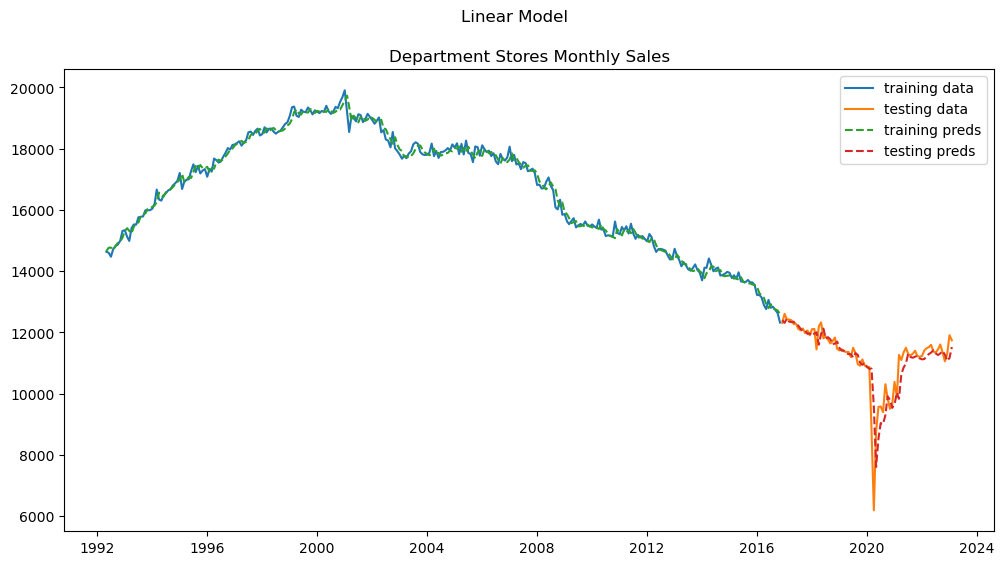

In [56]:
plot_preds(y_train, y_test, train_preds, test_preds, "Linear Model")

#### Evaluate the model

In [57]:
# Generate predicted test values and calculate R2 score.
lm_r2 = r2_score(y_test, test_preds)

# Calculate RMSE.
lm_rmse = mean_squared_error(y_test, test_preds) ** 0.5

# calculate the AIC value
n = len(y_test)
k = lm.df_model + 1  # +1 for the intercept term
rss = ((test_preds - y_test) ** 2).sum()
lm_aic = n * np.log(rss / n) + 2 * k

# Calculate MAE
lm_mae = mean_absolute_error(y_test, test_preds)

print(f"Linear model")
print(f"----")
print(f"R2 Score: {round(lm_r2, 3)}")
print(f"RMSE: {round(lm_rmse, 3)}")
print(f"AIC: {round(lm_aic, 3)}")
print(f"MAE: {round(lm_mae, 3)}")

Linear model
----
R2 Score: 0.675
RMSE: 581.987
AIC: 966.967
MAE: 306.025


#### Save the model

In [58]:
joblib.dump(lm, "../model/linear.joblib")

['../model/linear.joblib']

### (2) Fit an ARIMA model

In [59]:
# Train-test-Split
train, test = train_test_split(df[["sales"]], test_size=0.2, shuffle=False)

In [60]:
# Intantiate and fit the model
ar = ARIMA(endog=train, order=(4, 1, 3), freq="MS").fit()

# Generate prediction values
train_preds = ar.predict(start=train.index[0], end=train.index[-1])
test_preds = ar.predict(start=test.index[0], end=test.index[-1])

/Users/ayakohomma/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ayakohomma/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/ayakohomma/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/ayakohomma/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


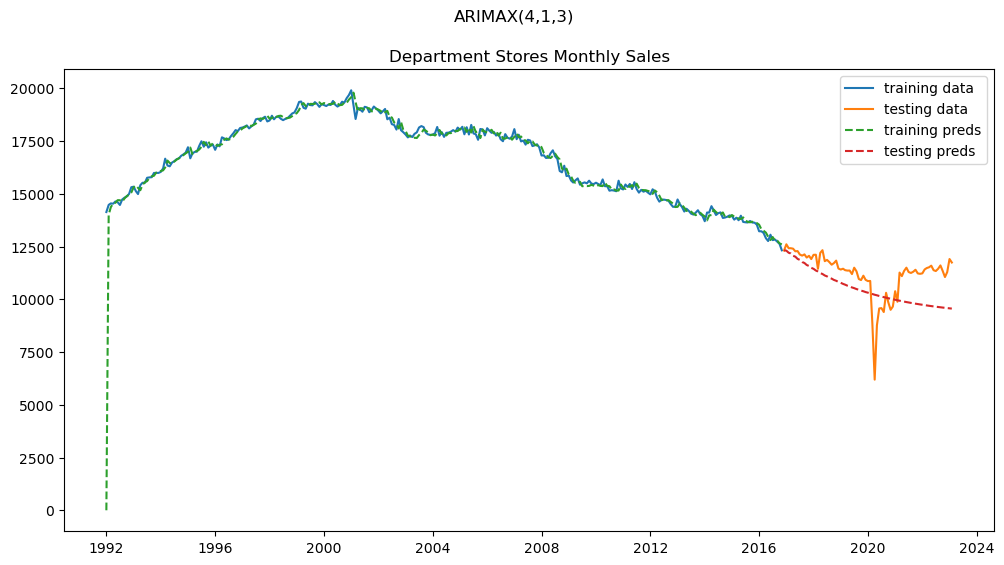

In [61]:
plot_preds(train, test, train_preds, test_preds, "ARIMAX(4,1,3)")

#### Evaluate the model

In [62]:
# Calculate AIC (Akaike Information Criterion). A lower AIC score indicates a better fit and a more parsimonious model
arima_aic = ar.aic

# Generate predicted test values and calculate R2 score.
arima_r2 = r2_score(test, test_preds)

# Calculate RMSE.
arima_rmse = mean_squared_error(test, test_preds) ** 0.5

# Calculate MAE
arima_mae = mean_absolute_error(y_test, test_preds)

print(f"ARIMA model")
print(f"----")
print(f"R2 Score: {round(arima_r2, 3)}")
print(f"RMSE: {round(arima_rmse, 3)}")
print(f"AIC: {round(arima_aic, 3)}")
print(f"MAE: {round(arima_mae, 3)}")

ARIMA model
----
R2 Score: -0.342
RMSE: 1181.795
AIC: 3981.306
MAE: 966.768


### (2) Fit a SARIMAX model

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.60292D+00    |proj g|=  8.73582D-02


/Users/ayakohomma/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  6.57863D+00    |proj g|=  4.24746D-02

At iterate   10    f=  6.57617D+00    |proj g|=  2.49842D-03

At iterate   15    f=  6.56908D+00    |proj g|=  3.25449D-02

At iterate   20    f=  6.55769D+00    |proj g|=  1.52820D-02

At iterate   25    f=  6.55387D+00    |proj g|=  3.01904D-03

At iterate   30    f=  6.55002D+00    |proj g|=  1.42480D-02

At iterate   35    f=  6.48723D+00    |proj g|=  1.28769D-02

At iterate   40    f=  6.46067D+00    |proj g|=  2.86955D-02

At iterate   45    f=  6.44901D+00    |proj g|=  1.49943D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     48     78      1     0     0   5.863D-03   6.449D+00
  F =   6.4486797147180193     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


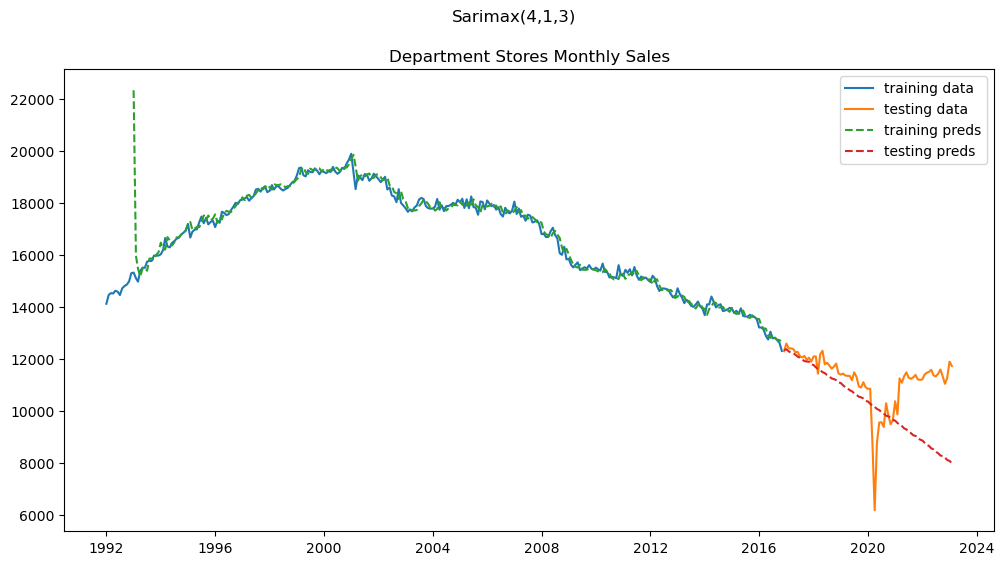

In [63]:
# Instantiate and fit the model
sarima = SARIMAX(train, order=(4, 1, 3), seasonal_order=(1, 1, 1, 12), freq="MS").fit()

# Generate prediction values
train_preds = sarima.predict(start=train.index[0], end=train.index[-1])
test_preds = sarima.predict(start=test.index[0], end=test.index[-1])

# Plot
plot_preds(train, test, train_preds, test_preds, "Sarimax(4,1,3)", truncate=12)

#### Evaluate the model

In [64]:
# Calculate AIC (Akaike Information Criterion). A lower AIC score indicates a better fit and a more parsimonious model
sarimax_aic = sarima.aic

# Generate predicted test values and calculate R2 score.
sarimax_r2 = r2_score(test, test_preds)

# Calculate RMSE.
sarimax_rmse = mean_squared_error(test, test_preds) ** 0.5

# Calculate MAE
sarimax_mae = mean_absolute_error(y_test, test_preds)

print(f"SARIMAX model")
print(f"----")
print(f"R2 Score: {round(sarimax_r2, 3)}")
print(f"RMSE: {round(sarimax_rmse, 3)}")
print(f"AIC: {round(sarimax_aic, 3)}")
print(f"MAE: {round(sarimax_mae, 3)}")

SARIMAX model
----
R2 Score: -1.593
RMSE: 1642.587
AIC: 3876.31
MAE: 1165.682


## Evaluation

Here are the scores and metrics for models: 

|Model|R2|RMSE|AIC|MAE|
|--|--|--|--|--|
|Linear model|0.675|581.987|966.967|306.025|
|ARIMA model(4,1,3)|-0.342|1181.795|3981.306|966.768|
|SARIMAX model(4,1,3)|-1.593|1642.587|3876.310|1165.682|

Based on the metrics table, the linear model seems to be performing the best out of the three models. The linear model has the highest R2 score and lowest RMSE value and AIC value. ARIMA and SARIMAX had negative R2 scores, meaning that they are performing worse than a model that simply predicts the mean of the target variable. They also have much higher RMSE and AIC values compared to the linear model.